In [2]:
import os
import json
import re
import logging
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from logging.handlers import RotatingFileHandler

from imblearn.over_sampling import SMOTE

from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.functions import col, lit, current_timestamp
from snowflake.snowpark.dataframe import DataFrame

from snowflake.ml.feature_store import FeatureStore, FeatureView, Entity, CreationMode
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.registry import Registry
from snowflake.ml.modeling.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Before running below, you need to copy the `.env.example` file to a new file called `.env`. This file will hold the configuration details for your environment.

Run the following command in your terminal:

```bash
cp .env.example .env
```

Open the newly created .env file in a text editor of your choice. Replace the placeholder values with your actual credentials.

In [3]:
class Config:
    def __init__(self):
        load_dotenv(dotenv_path=".env", verbose=True)
        self.account = os.getenv('ACCOUNT')
        self.user = os.getenv('USER')
        self.password = os.getenv('PASSWORD')
        self.role = "HOL1"
        self.warehouse = "HOL1_WH"
        self.database = "HOL1_DB"
        self.schema = "HOL1_SCHEMA"
        self.log_file = "../logs/HOL1.log"

load_dotenv(dotenv_path="../.env")
config = Config()

### Util function - set up logger

In [4]:
def setup_logger(name, log_file=config.log_file, level=logging.INFO, max_bytes=2000, backup_count=5):
    """
    Sets up a logger for logging information.
    """
    logger = logging.getLogger(name)
    logger.setLevel(level)
    
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    file_handler = RotatingFileHandler(log_file, maxBytes=max_bytes, backupCount=backup_count)
    file_handler.setFormatter(formatter)
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
    return logger

logger = setup_logger(name=__name__)

### Connect to Snowflake

In [5]:
def create_session():
    session = Session.builder.configs(
        options={
            'account': config.account,
            'user': config.user,
            'password': config.password,
            'role': config.role,
            'warehouse': config.warehouse,
            "database": config.database,
            'schema': config.schema,
        }
    ).create()
    return session

session = create_session()

### List of table names and column names for easier reference

In [6]:
application_record_table_name = "APPLICATION_RECORD"
credit_record_table_name = "CREDIT_RECORD"

model_name = "CREDIT_RISK_XGBoost"

application_record_fv_name = "application_record_features"

id_col = "ID"
target_col="TARGET"
output_col="PREDICT"
fv_name = "COMBINED_DATA"
fv_version = "V1"

### 0. Set up feature store

In [7]:
fs = FeatureStore(
    session=session,
    default_warehouse=config.warehouse,
    database=config.database,
    name="application_credit_feature_store",
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST
)

feature_views_df = fs.list_feature_views()
feature_views_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"NAME"  |"VERSION"  |"DATABASE_NAME"  |"SCHEMA_NAME"  |"CREATED_ON"  |"OWNER"  |"DESC"  |"ENTITIES"  |"REFRESH_FREQ"  |"REFRESH_MODE"  |"SCHEDULING_STATE"  |"WAREHOUSE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|        |           |                 |               |              |         |        |            |                |                |                    |             |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------



### 1. Feature engineering

In [8]:
application_record = session.table(f'{config.database}.{config.schema}.{application_record_table_name}')

def feature_engineering(application_record):
    """
    Applies feature engineering to the application record.
    """
    return application_record.with_column(
        'CNT_CHILDREN_IND', F.iff(F.col('CNT_CHILDREN') >= 2, "2+", F.to_varchar(F.col('CNT_CHILDREN')))
    ).drop('CNT_CHILDREN').with_column(
        'CNT_FAMILY_IND', F.iff(F.col('CNT_FAM_MEMBERS') >= 3, "3+", F.to_varchar(F.col('CNT_FAM_MEMBERS')))
    ).drop('CNT_FAM_MEMBERS').with_column(
        'AGE', F.abs(F.floor(F.col('DAYS_BIRTH') / 365))
    ).drop('DAYS_BIRTH').with_column(
        'WORKYEAR', F.abs(F.floor(F.col('DAYS_EMPLOYED') / 365))
    ).filter(F.col('WORKYEAR') < 50).drop('DAYS_EMPLOYED').with_column(
        'OCCUPATION_TYPE',
        F.iff(F.col('OCCUPATION_TYPE').in_(['Cleaning staff', 'Cooking staff', 'Drivers', 'Laborers', 'Low-skill Laborers', 'Security staff', 'Waiters/barmen staff']), 'LABOURWORK',
              F.iff(F.col('OCCUPATION_TYPE').in_(['Accountants', 'Core staff', 'HR staff', 'Medicine staff', 'Private service staff', 'Realty agents', 'Sales staff', 'Secretaries']), 'OFFICEWORK', 
                    F.iff(F.col('OCCUPATION_TYPE').in_(['Managers', 'High skill tech staff', 'IT staff']), 'HIGHTTECHWORK', 'OTHER')))
    )

application_record = feature_engineering(application_record)
application_record.show(2)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"     |"CODE_GENDER"  |"FLAG_OWN_CAR"  |"FLAG_OWN_REALTY"  |"AMT_INCOME_TOTAL"  |"NAME_INCOME_TYPE"  |"NAME_EDUCATION_TYPE"  |"NAME_FAMILY_STATUS"  |"NAME_HOUSING_TYPE"  |"FLAG_MOBIL"  |"FLAG_WORK_PHONE"  |"FLAG_PHONE"  |"FLAG_EMAIL"  |"CNT_CHILDREN_IND"  |"CNT_FAMILY_IND"  |"AGE"  |"WORKYEAR"  |"OCCUPATION_TYPE"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|5008804  |M              |Y      

In [9]:
credit_record = session.table(f'{config.database}.{config.schema}.{credit_record_table_name}')

def process_labels(credit_record: DataFrame):
    credit_record = credit_record.group_by('ID')\
        .agg(F.sum(F.iff(F.col('STATUS').in_(['2', '3', '4', '5']), 1, 0)).as_("CNT_LATE"))\
        .with_column(target_col, F.when(F.col('CNT_LATE') > 0, 1).otherwise(0))\
        .drop("CNT_LATE")

    return credit_record

credit_record = process_labels(credit_record)
credit_record.show(2)

----------------------
|"ID"     |"TARGET"  |
----------------------
|5001711  |0         |
|5001712  |0         |
----------------------



In [10]:
combined_data = application_record.join(credit_record, using_columns=id_col, join_type='inner')
combined_data.show(2)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"     |"CODE_GENDER"  |"FLAG_OWN_CAR"  |"FLAG_OWN_REALTY"  |"AMT_INCOME_TOTAL"  |"NAME_INCOME_TYPE"  |"NAME_EDUCATION_TYPE"  |"NAME_FAMILY_STATUS"  |"NAME_HOUSING_TYPE"  |"FLAG_MOBIL"  |"FLAG_WORK_PHONE"  |"FLAG_PHONE"  |"FLAG_EMAIL"  |"CNT_CHILDREN_IND"  |"CNT_FAMILY_IND"  |"AGE"  |"WORKYEAR"  |"OCCUPATION_TYPE"  |"TARGET"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|

Store the combined table into feature view, such that it is automatically updated when the underlying tables (application record & credit record) being updated

Go to Snowsight to view the dependency graph

In [11]:
# Create the FeatureView instance
fv_instance = FeatureView(
    name=fv_name, 
    entities=[], 
    feature_df=combined_data,
    refresh_freq='6 hours',           # <- specifying optional refresh_freq creates FeatureView as Dynamic Table, else created as View.
    desc="Features & labels for training"
)

# Register the FeatureView instance.  Creates  object in Snowflake
fs.register_feature_view(
    feature_view=fv_instance,
    version=fv_version, 
    block=True
)

fs.list_feature_views().select('NAME', 'VERSION').show()

-----------------------------
|"NAME"         |"VERSION"  |
-----------------------------
|COMBINED_DATA  |V1         |
-----------------------------



View refresh history of the feature view

In [12]:
fs.get_refresh_history(fv_name, fv_version).show()

-------------------------------------------------------------------------------------------------------------------------
|"NAME"            |"STATE"    |"REFRESH_START_TIME"              |"REFRESH_END_TIME"                |"REFRESH_ACTION"  |
-------------------------------------------------------------------------------------------------------------------------
|COMBINED_DATA$V1  |SUCCEEDED  |2024-10-10 15:45:49.516000-07:00  |2024-10-10 15:45:51.558000-07:00  |INCREMENTAL       |
-------------------------------------------------------------------------------------------------------------------------



### Apply One-Hot Encoding, Ordinal Encoding, and Standardization

Run the code below to apply one-hot encoding, ordinal encoding, and standardization on the feature vectors. 

If you encounter an error, try rerunning the code block.

**Note:** The feature view is created before the transformation because the transformation pipeline generates temporary tables. The feature store doesn't support saving these transformations, which should ideally be saved in the model registry.

In [13]:
combined_data = fs.get_feature_view(fv_name, fv_version).feature_df

categorical_columns = ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
                        'CNT_CHILDREN_IND', 'CNT_FAMILY_IND', 'OCCUPATION_TYPE', 'NAME_HOUSING_TYPE']
ordinal_columns = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']
numeric_columns = ['AMT_INCOME_TOTAL', 'AGE', 'WORKYEAR']

transformation_pipeline = Pipeline(
    steps=[
        ("OneHot", OneHotEncoder(input_cols=categorical_columns, output_cols=categorical_columns, drop_input_cols=True)),
        ("Ordinal", OrdinalEncoder(input_cols=ordinal_columns, output_cols=ordinal_columns)),
        ("Scaler", StandardScaler(input_cols=numeric_columns, output_cols=numeric_columns))
    ]
)

data_encoded = transformation_pipeline.fit(combined_data).transform(combined_data)
session.use_schema(config.schema)
data_encoded.write.save_as_table(table_name='CREDIT_RISK_PREPARED', mode='overwrite')

/opt/homebrew/anaconda3/envs/snowflake_mlops/lib/python3.11/site-packages/snowflake/ml/modeling/pipeline/pipeline.py:428: UserWarning: Warning: The Decimal(18, 2) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  snowpark_dataframe_utils.cast_snowpark_dataframe_column_types(dataset)


### Handling Class Imbalance

The dataset is imbalanced, with significantly more 'low-risk' than 'high-risk' customers. This can bias the model toward predicting the majority class ('low-risk'), leading to poor performance on the minority class ('high-risk').

**Class imbalance** occurs when one class (e.g., 'low-risk') dominates the dataset, which can cause the model to favor that class and result in inaccurate predictions for the minority class.

**Brainstorm:** Have you encountered similar situations where one category dominates and skews predictions? How did you handle it?

In [14]:
data_encoded.group_by('TARGET').count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|1         |503      |
|0         |29819    |
----------------------



In [16]:
# session.use_schema(config.schema)

@sproc(name="sproc_oversample_smote", is_permanent=True, stage_location=f"@ML_PROCS",
        replace=True, packages=['snowflake-snowpark-python==1.20.0', 'scikit-learn==1.2.2', 'imbalanced-learn==0.12.3'])
def sproc_oversample_smote(session: Session, training_table: str, feature_cols: T.List[str], target_col: str, target_table: str) -> T.Variant:
    """
    A Snowpark stored procedure for oversampling data using SMOTE and writing it back to Snowflake.
    """
    training_sdf = session.table(training_table)
    training_pdf = training_sdf.to_pandas()

    # Perform SMOTE oversampling
    X_balance, y_balance = SMOTE().fit_resample(training_pdf[feature_cols], training_pdf[target_col])
    X_balance[target_col] = y_balance

    # Write the oversampled data back to Snowflake
    session.sql(f"DROP TABLE IF EXISTS {target_table}").collect()
    session.write_pandas(X_balance, table_name=target_table, auto_create_table=True)

    return "Successfully over-sampled"


# SMOTE Oversampling
feature_cols = [col.strip('"') for col in data_encoded.columns if col not in ['TARGET', 'ID']]

# TODO: Call the stored procedure for SMOTE oversampling
# Pass in the session, the input table, the feature columns, the target column, and the output table.
sproc_oversample_smote(
    session, "CREDIT_RISK_PREPARED", feature_cols, "TARGET", "CREDIT_RISK_BALANCED"
)

data_rebalanced = session.table(f"CREDIT_RISK_BALANCED")

In [17]:
data_rebalanced.group_by('TARGET').count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|0         |29819    |
|1         |29819    |
----------------------



### Train test split and train model

Cross-validation should be used for more reliable model evaluation., but this example uses a fixed 80-20 split.

### Build Two Model Versions

1. Build the **first version** using prior-balancing `CREDIT_RISK_PREPARED`.
2. Build the **second version** using after-balancing `CREDIT_RISK_BALANCED`.

Compare the performance of the two versions.

In [19]:
# TODO: Load the CREDIT_RISK_PREPARED (v1) or CREDIT_RISK_BALANCED (v2) and split it into training and test sets
# Use a random split with 80% for training and 20% for testing. Don't forget to set the random seed.

# data_rebalanced = session.table("CREDIT_RISK_PREPARED")
data_rebalanced = session.table("CREDIT_RISK_BALANCED")

train_data, test_data = data_rebalanced.randomSplit([0.8, 0.2], seed=0)
train_data.count(), test_data.count()

(47574, 12064)

### Train an XGBClassifier

You can easily switch the classifier to `snowflake.ml.modeling.linear_model.LinearRegression`, `snowflake.ml.modeling.ensemble.RandomForestClassifier`, or others, and compare their performance.

Simply update the classifier in the code and re-run the cell to observe the differences.

In [20]:
feature_cols = [col for col in train_data.columns if col != target_col]

# Model training
# switch into classifier
model = XGBClassifier(input_cols=feature_cols, label_cols=[target_col], output_cols=[output_col])
model.fit(train_data)

### Model Evaluation Metrics

- **Accuracy**: The proportion of correctly predicted instances out of the total instances.
- **Precision**: The proportion of true positive predictions out of all predicted positives (measures how accurate positive predictions are).
- **Recall**: The proportion of true positive predictions out of all actual positives (measures the ability to detect positive instances).
- **F1 Score**: The harmonic mean of precision and recall, balancing both to provide a single metric for performance.

For a more detailed explanation, try prompting "explain to me accuracy, confusion matrix, precision, recall, F1 score" in ChatGPT

In [21]:
result = model.predict(test_data)

metrics = {
    'Accuracy': accuracy_score(df=result, y_true_col_names='TARGET', y_pred_col_names='PREDICT'),
    'Precision': precision_score(df=result, y_true_col_names='TARGET', y_pred_col_names='PREDICT'),
    'Recall': recall_score(df=result, y_true_col_names='TARGET', y_pred_col_names='PREDICT'),
    'F1 Score': f1_score(df=result, y_true_col_names='TARGET', y_pred_col_names='PREDICT')
}

metrics

{'Accuracy': 0.991628,
 'Precision': 0.990811894420314,
 'Recall': 0.9923038313535218,
 'F1 Score': 0.9915573016801805}

### Save to model registry

Go to Snowsight to see model object under HOL1_DB > HOL1_SCHEMA > Models

In [22]:
model_registry = Registry(session=session, database_name=config.database, schema_name=config.schema)

# a helper function to get the latest model version, if not found, return V1
def get_new_model_version(model_name: str) -> str:
    try:
        new_version = re.sub(r'\bV(\d+)\b', lambda m: f"V{int(m.group(1)) + 1}", model_registry.get_model(model_name).last().version_name)
    except:
        new_version = "V1"
    return new_version

def log_model(model_name, model, metrics, version_name, sample_data):
    model_registry.log_model(
        model_name=model_name,
        model=model,
        metrics=metrics,
        version_name=version_name,
        sample_input_data=sample_data.limit(10)
    )
    logger.info(f"Model {model_name} logged with version {version_name}")

log_model(model_name, model, metrics, get_new_model_version(model_name), train_data.limit(10))

2024-10-11 09:56:39,668 - __main__ - INFO - Model CREDIT_RISK_XGBoost logged with version V1
INFO:__main__:Model CREDIT_RISK_XGBoost logged with version V1


### Feature importance analysis

XGBoost provides a **feature importance** score, which measures the contribution of each feature to the model's predictions. This is calculated based on how often and how effectively the feature is used in decision trees. Features with higher importance scores are more influential in driving the model's decisions.

In the **Feature Importance** bar chart, we can see that `FLAG_OWN_REALTY` has the highest importance score. This means that owning real estate has a strong influence on the model’s predictions.

<Axes: >

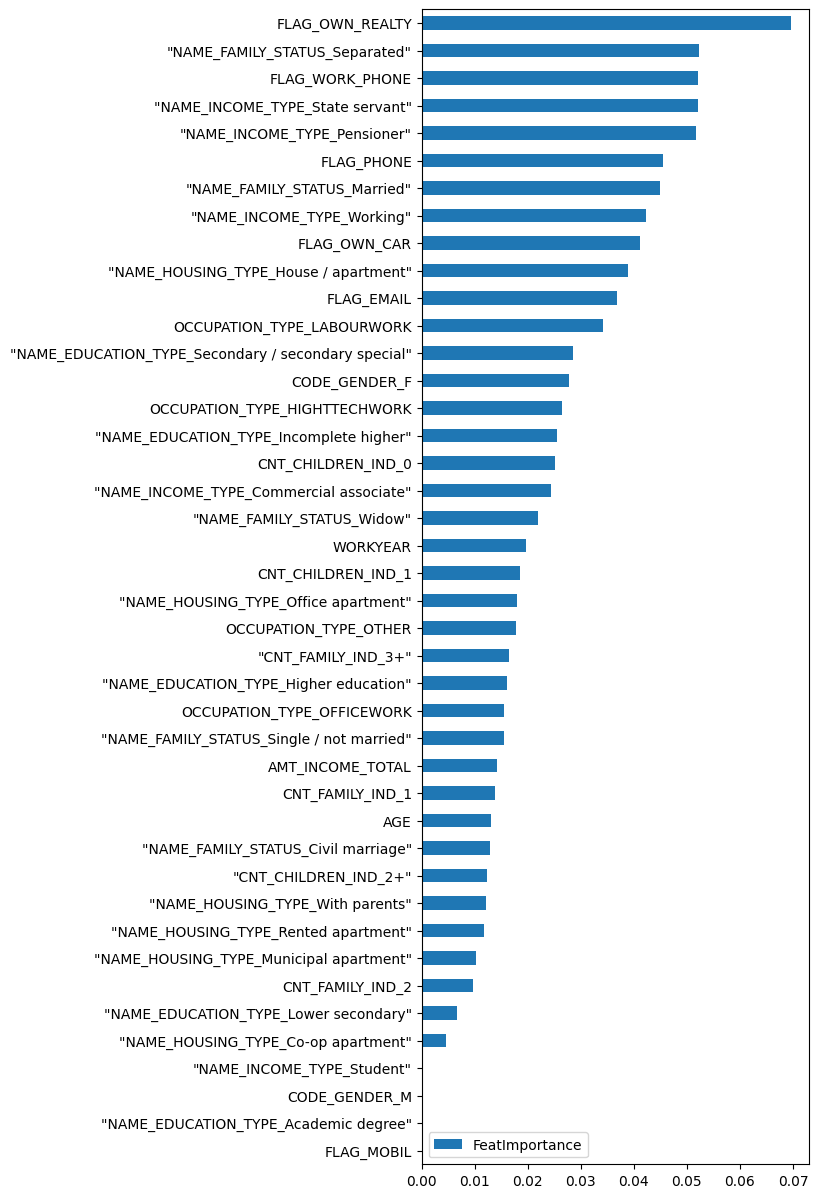

In [23]:
import matplotlib
model_local = model.to_xgboost()

# Plot feature importance
feat_importance = pd.DataFrame(model_local.feature_importances_,model_local.feature_names_in_,columns=['FeatImportance'])
feat_importance.sort_values('FeatImportance').plot.barh(y='FeatImportance', figsize=(5,15))

### SHAP Values

**SHAP (SHapley Additive exPlanations)** values provide a way to understand the impact of each feature on the model’s output for individual predictions. SHAP assigns each feature a value representing its contribution to pushing the prediction away from the base value (mean prediction). 

In the **SHAP summary plot** below, the color represents the feature's value (blue for low and pink for high). The SHAP values indicate how much each feature contributes to increasing or decreasing the prediction. For example, higher values of `AGE` (shown in pink) tend to increase the predicted risk, while lower values (in blue) decrease it.

In both graphs, we see that `FLAG_OWN_REALTY` and `AGE` are important features, but the SHAP plot shows us more context. For instance, in the SHAP plot, older age (higher values of `AGE`, pink) is shown to increase the risk, while younger age (blue) lowers the risk. This kind of insight helps explain why the feature is important and how it influences specific predictions.

 99%|===================| 47012/47574 [01:10<00:00]        

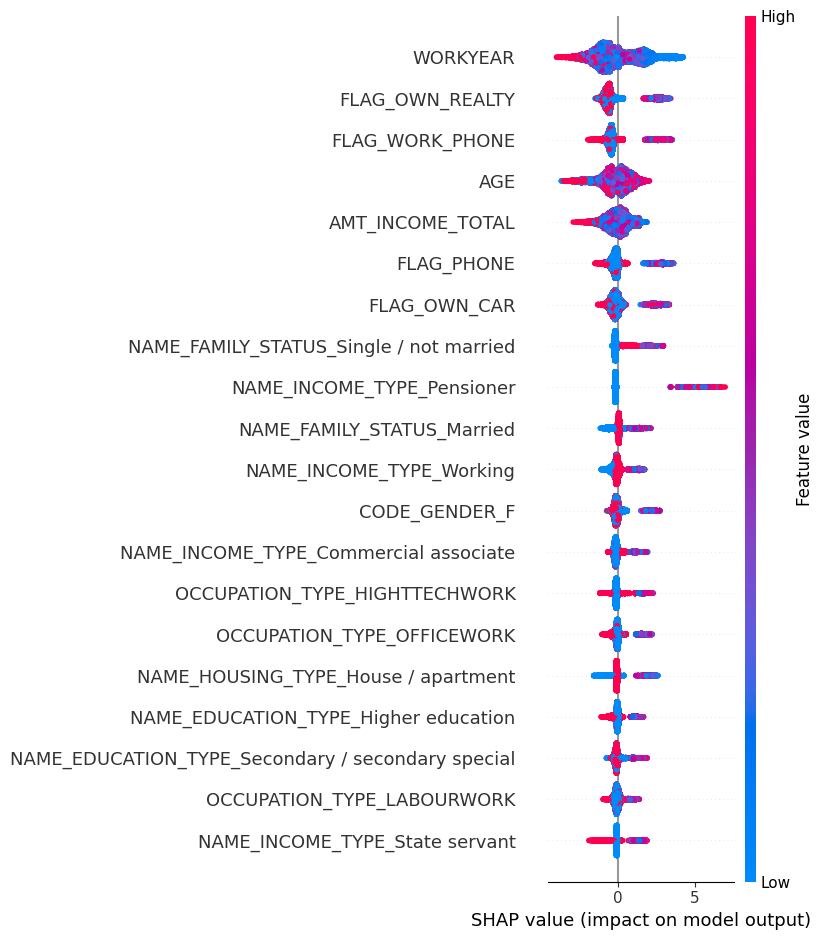

In [25]:
import shap
X_data = train_data.to_pandas()
explainer = shap.Explainer(model_local, X_data)
shap_values = explainer(X_data)
shap.summary_plot(shap_values, X_data, show=True)

### Build a Streamlit App for Single Customer Inference

In this step, we will set up a Streamlit app to perform inference on a new customer. 

1. Run the two cells below to create a stored procedure that will handle the inference.
2. Once the stored procedure is set up, we will integrate it with the Streamlit app to process customer data and return predictions.

Go ahead and run the following two cells:


This stored procedure, `sproc_predict_new_customer`, performs inference on new customer data using an XGBoost model:

1. **Model Versioning**: Fetches the latest model version from the registry if none is provided.
2. **Data Handling**: Converts the new customer records into a Snowpark DataFrame.
3. **Duplicate Check**: Leftanti joins with the `prediction_table` to ensure only new records are processed.
4. **Feature Engineering & Prediction**: Applies transformations, runs predictions, and appends results to the `prediction_table`.
5. **Return Predictions**: Returns all predictions (both new and existing) made for the given customer(s).

In [26]:
@sproc(name="sproc_predict_new_customer", is_permanent=True, stage_location="@ML_PROCS",
       replace=True, packages=['snowflake-snowpark-python', 'snowflake-ml-python==1.6.1', 'xgboost==1.7.6', 'pandas'],
       imports=["@ML_PROCS/utils.py.gz"]
    )
def predict_new_customer(
    session: Session,
    new_customer_record: list[dict],  # Single dict for one customer, list of dicts for batch inference
    database_name: str = 'HOL1_DB',
    schema_name: str = 'HOL1_SCHEMA',
    model_name: str = 'CREDIT_RISK_XGBOOST',
    prediction_table: str = 'PREDICTION_RESULTS',
    model_version: str = None
) -> str:
    from utils import feature_engineering
    from snowflake.snowpark.functions import col, lit

    # Initialize model registry and fetch the latest version if not provided
    model_registry = Registry(session=session, database_name=database_name, schema_name=schema_name)
    model_version = model_version or model_registry.get_model(model_name).last().version_name

    # If it's a single record, convert it into a Snowpark DataFrame
    new_customer_record = session.create_dataframe(new_customer_record)

    # Add model_version as a column to the customer records for the join
    customer_with_version = new_customer_record.with_column("MODEL_VERSION", lit(model_version))

    # Left join to find records in single_customer_record that are not in prediction_table
    prediction_table_df = session.table(prediction_table).alias("pred_tbl")
    records_to_predict = customer_with_version.join(
        prediction_table_df,
        on=["ID", "MODEL_VERSION"],
        how="leftanti"  # Keep only records that do not exist in prediction_table
    )

    # If there are any records that need prediction
    if records_to_predict.count() > 0:
        model = model_registry.get_model(model_name).version(model_version).load()

        # Apply feature engineering and transformation pipeline
        records_to_predict = transformation_pipeline.transform(feature_engineering(records_to_predict))
        
        # Make predictions
        prediction_results = model.predict(records_to_predict).with_column("MODEL_VERSION", lit(model_version))
        prediction_results.select("ID", "PREDICT", "MODEL_VERSION").write.save_as_table(prediction_table, mode="append")

    # Return all predictions (both existing and new)
    all_predictions = session.table(prediction_table).filter(
        col("ID").cast("STRING").in_(new_customer_record.select(col("ID").cast("STRING"))) &
        (col("MODEL_VERSION") == lit(model_version))
    ).select("ID", "PREDICTION")
    all_predictions_dict = str(all_predictions.to_pandas().set_index('ID')['PREDICTION'].to_dict())

    return all_predictions_dict

Follow these steps to deploy and run the Streamlit app in Snowsight:

1. Navigate to Snowsight > Projects > Streamlit, and create a new app. Make sure you choose to deploy using role HOL1, with the app location set to HOL1_DB.HOL1_SCHEMA. 
2. Copy and paste the contents of `app.py` into the new app.
3. Before running the app, ensure that the snowflake-ml-python package is selected in the list of dependencies.
4. Run the app, then click **"Predict"** to generate predictions for the default customer.

Based on the **feature importance analysis**, identify which features have the greatest impact on the model's predictions. You can use the **Streamlit** app to explore and interact with different prediction results.

**Note**: In the current implementation, if an existing `(ID, model_version)` pair is found in the `prediction_table`, the feature will **not** be re-evaluated, even if the underlying data has changed. To view updated predictions, ensure you select a **new ID** along with the desired model version.

In [27]:
session.table('PREDICTION_RESULTS').show()

--------------------------------------------
|"ID"     |"PREDICTION"  |"MODEL_VERSION"  |
--------------------------------------------
|5008804  |1             |V1               |
|5008800  |0             |V1               |
--------------------------------------------



### Batch inference pipeline

This pipeline performs batch predictions, evaluates the model, and triggers retraining if the F1 score falls below a threshold.

1. **`batch_predict_and_evaluate`**: Transforms features, predicts, evaluates F1 score, and triggers retraining if F1 score < 70%.
2. **`append_data_to_original_tables`**: Appends new records and refreshes the feature view.
3. **`retrain_model`**: Retrieves feature view, applies transformations, retrains the model, and logs a new version.

In [28]:
from utils import feature_engineering

def batch_predict_and_evaluate(
    session: Session, new_application_record_name: str, new_credit_record_name: str, model_name: str, model_version: str = None,
    database_name: str = 'HOL1_DB',
    schema_name: str = 'HOL1_SCHEMA',
    threshold: float = 0.7
):
    # Combine data loading and transformation
    new_application_record = transformation_pipeline.transform(
        feature_engineering(session.table(new_application_record_name))
    )

    # Combine model loading and version selection
    model_version = model_version or model_registry.get_model(model_name).last().version_name
    model = model_registry.get_model(model_name).version(model_version).load()

    # Make predictions
    predictions_df = model.predict(new_application_record).select(F.col('ID'), F.col('PREDICT'))

    # Process labels
    new_credit_record = process_labels(session.table(new_credit_record_name))

    # Join predictions with labels and calculate F1 score
    evaluation_df = predictions_df.join(new_credit_record, on="ID")
    f1 = f1_score(df=evaluation_df, y_true_col_names='TARGET', y_pred_col_names='PREDICT')

    logger.info(f"F1 score: {f1}")
    
    # Check if retraining is needed
    if f1 < threshold:
        append_data_to_original_tables(session, new_application_record_name, new_credit_record_name)
        logger.info(f"Starting re-training... from model version: {model_version}")
        retrain_model(session, model_name, model_version)
    else:
        # Calculate and log metrics
        metrics = {
            'Accuracy': accuracy_score(df=evaluation_df, y_true_col_names='TARGET', y_pred_col_names='PREDICT'),
            'Precision': precision_score(df=evaluation_df, y_true_col_names='TARGET', y_pred_col_names='PREDICT'),
            'Recall': recall_score(df=evaluation_df, y_true_col_names='TARGET', y_pred_col_names='PREDICT'),
            'F1 Score': f1
        }
        logger.info(f"Metrics (Accuracy: {metrics['Accuracy']}, Precision: {metrics['Precision']}, Recall: {metrics['Recall']}, F1: {metrics['F1 Score']})")

def append_data_to_original_tables(session: Session, new_application_record_name: str, new_credit_record_name: str):
    # Load new data
    new_application_record = session.table(new_application_record_name)
    new_credit_record = session.table(new_credit_record_name)

    # Fetch table count once and append data
    table = session.table(f"{config.database}.{config.schema}.{application_record_table_name}")
    count_before = table.count()

    new_application_record.write.save_as_table(application_record_table_name, mode="append")
    new_credit_record.write.save_as_table(credit_record_table_name, mode="append")

    logger.info(f"Data length before append: {count_before}, after append: {table.count()}")

    # Refresh feature view
    fs.refresh_feature_view(fv_name, fv_version)
    logger.info(f'Feature view {fv_name} refreshed')

def retrain_model(session: Session, model_name, model_version):
    # Get updated feature view
    combined_data = fs.get_feature_view(fv_name, fv_version).feature_df
    
    # Encode and save data
    data_encoded = transformation_pipeline.fit(combined_data).transform(combined_data)
    data_encoded.write.save_as_table(table_name='CREDIT_RISK_PREPARED', mode='overwrite')
    
    # SMOTE Oversampling
    feature_cols = [col.strip('"') for col in data_encoded.columns if col not in ['TARGET', 'ID']]
    sproc_oversample_smote(session, "CREDIT_RISK_PREPARED", feature_cols, "TARGET", "CREDIT_RISK_BALANCED")
    data_rebalanced = session.table("CREDIT_RISK_BALANCED")

    # Split data for training and testing
    train_data, test_data = data_rebalanced.randomSplit([0.8, 0.2], seed=0)

    # Load the model and retrain
    model = model_registry.get_model(model_name).version(model_version).load()
    model.fit(train_data)
    logger.info(f"Retrained model with version: {model_version}")

    result = model.predict(test_data)

    # Model evaluation and logging
    metrics = {
        'Accuracy': accuracy_score(df=result, y_true_col_names='TARGET', y_pred_col_names='PREDICT'),
        'Precision': precision_score(df=result, y_true_col_names='TARGET', y_pred_col_names='PREDICT'),
        'Recall': recall_score(df=result, y_true_col_names='TARGET', y_pred_col_names='PREDICT'),
        'F1 Score': f1_score(df=result, y_true_col_names='TARGET', y_pred_col_names='PREDICT')
    }

    # Increment model version and log
    new_version = re.sub(r'\bV(\d+)\b', lambda m: f"V{int(m.group(1)) + 1}", model_registry.get_model(model_name).last().version_name)
    log_model(model_name, model, metrics, new_version, train_data)
    logger.info(f'Model retrained successfully with updated metrics {metrics}')


### Trigger New Model with Synthetic Data

Use the **synthetically generated** batch of data to trigger the model evaluation. 

Since the data is synthetic, it is expected to produce a **very low F1 score**, which will trigger model retraining.

In [29]:
batch_predict_and_evaluate(
    session, 'NEW_APPLICATION_RECORD', 'NEW_CREDIT_RECORD', 'CREDIT_RISK_XGBoost'
)

2024-10-11 10:04:37,083 - __main__ - INFO - F1 score: 0.15384615384615383
INFO:__main__:F1 score: 0.15384615384615383
2024-10-11 10:04:42,785 - __main__ - INFO - Data length before append: 438557, after append: 439057
INFO:__main__:Data length before append: 438557, after append: 439057
2024-10-11 10:04:53,220 - __main__ - INFO - Feature view COMBINED_DATA refreshed
INFO:__main__:Feature view COMBINED_DATA refreshed
2024-10-11 10:04:53,222 - __main__ - INFO - Starting re-training... from model version: V1
INFO:__main__:Starting re-training... from model version: V1
2024-10-11 10:08:28,208 - __main__ - INFO - Retrained model with version: V1
INFO:__main__:Retrained model with version: V1
2024-10-11 10:10:01,661 - __main__ - INFO - Model CREDIT_RISK_XGBoost logged with version V2
INFO:__main__:Model CREDIT_RISK_XGBoost logged with version V2
2024-10-11 10:10:01,664 - __main__ - INFO - Model retrained successfully with updated metrics {'Accuracy': 0.991386, 'Precision': 0.9911578244911579

Verify the the feature view has been updated

In [30]:
fs.get_refresh_history(fv_name, fv_version).show()

-------------------------------------------------------------------------------------------------------------------------
|"NAME"            |"STATE"    |"REFRESH_START_TIME"              |"REFRESH_END_TIME"                |"REFRESH_ACTION"  |
-------------------------------------------------------------------------------------------------------------------------
|COMBINED_DATA$V1  |SUCCEEDED  |2024-10-10 16:04:47.261000-07:00  |2024-10-10 16:04:49.306000-07:00  |INCREMENTAL       |
|COMBINED_DATA$V1  |SUCCEEDED  |2024-10-10 15:45:49.516000-07:00  |2024-10-10 15:45:51.558000-07:00  |INCREMENTAL       |
-------------------------------------------------------------------------------------------------------------------------



Verify new model version is logged

In [31]:
model_registry.get_model(model_name).show_versions()

,created_on,name,aliases,comment,database_name,schema_name,model_name,is_default_version,functions,metadata,user_data
0,2024-10-10 15:56:35.136000-07:00,V1,"[""DEFAULT"",""FIRST""]",None,HOL1_DB,HOL1_SCHEMA,CREDIT_RISK_XGBOOST,true,"[""PREDICT_PROBA"",""PREDICT""]","{""metrics"": {""Accuracy"": 0.991628, ""Precision""...",{}
1,2024-10-10 16:09:58.418000-07:00,V2,"[""LAST""]",None,HOL1_DB,HOL1_SCHEMA,CREDIT_RISK_XGBOOST,false,"[""PREDICT_PROBA"",""PREDICT""]","{""metrics"": {""Accuracy"": 0.991386, ""Precision""...",{}


### View Updated Results in Streamlit

Navigate to the **Streamlit** app and select **model version V2** to view the updated prediction results based on the latest data.

In [32]:
session.close()